# Text Prediction and Generation using LSTM Networks

_______________
## Google drive code only
Only run the following sections in a colaboratory shell

In [ ]:
%%time
# Code to read google drive files into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Google drive code only
%%time
def importFile(fileName: str, fileID: str):
  '''Imports a file into the Colaboratory workspace. The fileID can be 
     found in the file's Share Link'''
  print("Grabbing file " + str(fileName) + " with id = " + str(fileID)) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':fileID}) 
  downloaded.GetContentFile(fileName) 

In [ ]:
# Google drive code only
# Import all the datasets we are going to use for our project
importFile('TheLordOfTheRings_Book1.txt', '1crAeSigOaQcT62W7EjcwrKcIVBx5ayeh')
importFile('GoogleNews-vectors-negative300.bin', '1zzUeVFsRYw3lWe6kjk1nccywCkMDp-AY')

## End of Google drive code
_________________________________________

In [1]:
# Load top 1 million (out of 3 million) word embeddings from the binary file.
# These vectors are 300 dimensions large and are created using the word2vec algorithm.
# The model was trained on the GoogleNews corpus, which is a similar size to the English version of Wikipedia.
# We can only load 1 million vectors because we run out of RAM.

# %%time
import gensim
import numpy as np

embeddings = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', limit=1000000, binary=True)
# Hot fix for terms that do not exist inside the GoogleNews vocabulary
unknown = np.random.rand(300)
embeddings.add("<Unknown>", unknown)

### Word Embedding Examples

When we import the binary file using the gensim library, we can easily explore interesting properties of word embeddings. Much like a latent vector produced using an autoencoder, each embedding holds meaningful information about each word and the context in which it is used. The following examples explore the latent space in which these vectors reside.

In [2]:
# We can perform interesting vector addition/subtraction
print(embeddings.most_similar(positive=["boy", "girl"], topn=3))
print(embeddings.most_similar(positive=["fish"], negative=["water"], topn=3)) # What is a fish without water?

# We can extract nearby points. This feature will be useful because our model 
# won't output vectors that exactly correspond to existing vectors.
v = np.copy(embeddings["woman"])
v[0] += 0.2
print(embeddings.most_similar(positive=[v], topn=1))

[('teenage_girl', 0.7674505114555359), ('teenager', 0.7674364447593689), ('toddler', 0.701943576335907)]
[('striped_bass', 0.47242963314056396), ('bluefin', 0.449390709400177), ('tunas', 0.4461328089237213)]
[('woman', 0.9972376227378845)]


![](https://drive.google.com/uc?export=view&id=1e9PxMNKjTXDx7KZDxHpC4ENmz0sXHl_g)

## Preprocessing 
This is were we generate the training and validation data for our LSTM. The following functions will be used in the following sections.

In [3]:
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import LSTM, Dense
from nltk import ngrams
import math
import numpy as np
import re


def tokenizeFile(fileName: str) -> list:
  '''Will take in the name of a txt file located in the base directory 
     of the drive and return a list of terms'''
  words = []
  with open(fileName, 'r', encoding="ISO-8859-1") as myTxtFile:
    for line in myTxtFile:
      lineWords = [word for word in re.split(r'[^a-zA-Z]', line.strip()) if word]
      words += lineWords
  return words


def flipFirstChar(word: str) -> str:
  '''Capitalizes/Un-capitalizes the first character of the word'''
  if word[0].isupper():
    return word[0].lower() + word[1:]
  else:
    return word[0].upper() + word[1:]


def wordsToVectors(words: list) -> (list, list):
  '''Convert a list of terms into a list of word embeddings. 
     We also keep track of which terms cannot be paired with an embedding.'''
  vectors = []
  unknownWords = set()
  for word in words:
    if word in embeddings:
        vectors.append(embeddings[word])
    elif flipFirstChar(word) in embeddings:
        vectors.append(embeddings[flipFirstChar(word)])
    else:
        vectors.append(unknown)
        unknownWords.add(word)
  return vectors, unknownWords


def phrasesToVectors(phrases: list, summary=True) -> (list, list):
    '''Calls wordsToVectors() on a list of lists. This function will be called
       after data is split into ngrams. Each phrase in the code below operations
       on a single ngram.'''
    phrase_vectors = []
    all_unknown_words = set()
    for phrase in phrases:
        vectors, unknown_words = wordsToVectors(phrase)
        phrase_vectors.append(vectors)
        all_unknown_words = all_unknown_words.union(unknown_words)  
    if summary:
      print("Number of training phrases: " + str(len(phrase_vectors)))
      print("Number of unknown terms: " + str(len(all_unknown_words)))
    print(np.shape(phrase_vectors))
    return np.array(phrase_vectors, dtype=np.ndarray), all_unknown_words

Using TensorFlow backend.


### Preprocessing Steps:

1. Split training data into individual tokens, ie: "Here is a sentence" --> \["Here" "is" "a" "sentence"\]
2. Use nltk to split training data into ngram phrases to feed into our LSTM network
    - The model's architecture will automatically adjust based on ngram size
3. Shuffle the data
4. Split the data into training and validation

In [4]:
%%time
words = tokenizeFile("TheLordOfTheRings_Book1.txt")
# Change this parameter to decrease or increase the size of the training samples
# The last element in each phrase is the vector that the LSTM network will
# try to predict.
N = 5
ngrams_words = ngrams(words, N + 1)
ngram_vectors_original, _ = phrasesToVectors(ngrams_words)

# NOT SURE IF WE SHOULD SHUFFLE OR LEAVE IN ORIGINAL ORDER
#np.random.shuffle(ngram_vectors_original)

Number of training phrases: 190112
Number of unknown terms: 548
(190112, 6, 300)
Wall time: 17.1 s


In [5]:
%%time
# This block of code cuts the data to make training go faster during experimentation
def divideSamplesBy(divisor: int, ngram_vectors_original):
    total_size = np.size(ngram_vectors_original, axis=0)
    ngram_vectors = ngram_vectors_original[:total_size//divisor]
    adjusted_size = np.size(ngram_vectors, axis=0)
    percentage = (adjusted_size/total_size) * 100
    print("Using %.2f percent of samples" % percentage)
    return ngram_vectors
    
ngram_vectors = divideSamplesBy(20, ngram_vectors_original)
# ngram_vectors = divideSamplesBy(1, ngram_vectors_original)
print("Samples Shape: " + str(ngram_vectors.shape))

Using 5.00 percent of samples
Samples Shape: (9505, 6, 300)
Wall time: 1.02 ms


### Training/Validation Split
First we will set aside some data for validation. The default is 10% of the data

Each phrase (element) in ngram_vectors will be split into two parts. All the terms preceeding the last term will be used to predict the last term. So, if we have an array of phrases of size six, then these phrases will be split into two arrays: one of size five and one of size one. For example: 

phrase: \[This tale grew in the telling\] --> \[This tale grew in the\] \[telling\]
 - input data = \[This tale grew in the\]
 - expected output = \[telling\]

In [6]:
# Split data into training and validation
split = math.floor(np.size(ngram_vectors, axis=0) * 0.9)
training = ngram_vectors[:split,:,:]
validation = ngram_vectors[split:,:,:]

# Split the training and validation data as discussed above ^
train_input = training[:,:-1,:]
# train_predict = np.expand_dims(training[:,-1,:], axis=1)
train_predict = training[:,1:,:]


validation_input = validation[:,:-1,:]
# validation_predict = np.expand_dims(validation[:,-1,:], axis=1)
validation_predict = validation[:,1:,:]

print("Training Input: " + str(train_input.shape) + ", Training Predict: " + str(train_predict.shape))
print("Validation Input: " + str(validation_input.shape) + ", Validation Predict: " + str(validation_predict.shape))

Training Input: (8554, 5, 300), Training Predict: (8554, 5, 300)
Validation Input: (951, 5, 300), Validation Predict: (951, 5, 300)


## Architecture Explaination
- The input shape is 300 because we take in each dimension of the word embedding as input
- Sigmoid activations are used because word embeddings are normalized betweeen zero and one
- Loss is cosine similarity because word2vec also uses cosine similarity to measure the distance between word vectors

In [23]:
input_shape=(N, 300)
print("Input Shape: " + str(input_shape))

model = Sequential()  
model.add(LSTM(300, input_shape=input_shape, return_sequences=True, activation='sigmoid'))
model.add(LSTM(300, return_sequences=True, activation='sigmoid'))
model.add(LSTM(300, return_sequences=True, activation='sigmoid'))
model.add(Dense(300))

model.compile(loss='cosine_proximity', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Input Shape: (5, 300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
dense_2 (Dense)              (None, 5, 300)            90300     
Total params: 2,253,900
Trainable params: 2,253,900
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
%%time
history = model.fit(train_input, train_predict, epochs=400, batch_size=64, verbose=2, validation_data=(validation_input, validation_predict))

Train on 8554 samples, validate on 951 samples
Epoch 1/400
 - 6s - loss: -3.7749e-01 - acc: 0.0418 - val_loss: -3.6137e-01 - val_acc: 0.0526
Epoch 2/400
 - 4s - loss: -3.8803e-01 - acc: 0.0444 - val_loss: -3.6215e-01 - val_acc: 0.0526
Epoch 3/400
 - 4s - loss: -3.8802e-01 - acc: 0.0444 - val_loss: -3.6215e-01 - val_acc: 0.0526
Epoch 4/400
 - 4s - loss: -3.8804e-01 - acc: 0.0444 - val_loss: -3.6252e-01 - val_acc: 0.0526
Epoch 5/400
 - 4s - loss: -3.8807e-01 - acc: 0.0444 - val_loss: -3.6168e-01 - val_acc: 0.0526
Epoch 6/400
 - 4s - loss: -3.8822e-01 - acc: 0.0444 - val_loss: -3.6339e-01 - val_acc: 0.0526
Epoch 7/400
 - 4s - loss: -3.9259e-01 - acc: 0.0525 - val_loss: -3.7256e-01 - val_acc: 0.0978
Epoch 8/400
 - 4s - loss: -4.0227e-01 - acc: 0.0897 - val_loss: -3.7949e-01 - val_acc: 0.0965
Epoch 9/400
 - 4s - loss: -4.1164e-01 - acc: 0.0886 - val_loss: -3.8846e-01 - val_acc: 0.0955
Epoch 10/400
 - 4s - loss: -4.2003e-01 - acc: 0.0882 - val_loss: -3.9347e-01 - val_acc: 0.0938
Epoch 11/400

Epoch 87/400
 - 4s - loss: -6.5874e-01 - acc: 0.2713 - val_loss: -3.2694e-01 - val_acc: 0.0848
Epoch 88/400
 - 4s - loss: -6.5947e-01 - acc: 0.2715 - val_loss: -3.2948e-01 - val_acc: 0.0835
Epoch 89/400
 - 4s - loss: -6.6072e-01 - acc: 0.2718 - val_loss: -3.2534e-01 - val_acc: 0.0875
Epoch 90/400
 - 4s - loss: -6.6209e-01 - acc: 0.2745 - val_loss: -3.2644e-01 - val_acc: 0.0812
Epoch 91/400
 - 4s - loss: -6.6331e-01 - acc: 0.2745 - val_loss: -3.2424e-01 - val_acc: 0.0854
Epoch 92/400
 - 4s - loss: -6.6434e-01 - acc: 0.2754 - val_loss: -3.2730e-01 - val_acc: 0.0873
Epoch 93/400
 - 4s - loss: -6.6586e-01 - acc: 0.2767 - val_loss: -3.2690e-01 - val_acc: 0.0843
Epoch 94/400
 - 4s - loss: -6.6681e-01 - acc: 0.2786 - val_loss: -3.2362e-01 - val_acc: 0.0839
Epoch 95/400
 - 4s - loss: -6.6738e-01 - acc: 0.2794 - val_loss: -3.2762e-01 - val_acc: 0.0881
Epoch 96/400
 - 4s - loss: -6.6823e-01 - acc: 0.2790 - val_loss: -3.2360e-01 - val_acc: 0.0877
Epoch 97/400
 - 4s - loss: -6.7000e-01 - acc: 0.28

Epoch 173/400
 - 4s - loss: -7.2173e-01 - acc: 0.3291 - val_loss: -3.0541e-01 - val_acc: 0.0787
Epoch 174/400
 - 4s - loss: -7.2217e-01 - acc: 0.3296 - val_loss: -3.1256e-01 - val_acc: 0.0784
Epoch 175/400
 - 4s - loss: -7.2221e-01 - acc: 0.3295 - val_loss: -3.0757e-01 - val_acc: 0.0810
Epoch 176/400
 - 4s - loss: -7.2368e-01 - acc: 0.3317 - val_loss: -3.1468e-01 - val_acc: 0.0824
Epoch 177/400
 - 4s - loss: -7.2414e-01 - acc: 0.3314 - val_loss: -3.1227e-01 - val_acc: 0.0841
Epoch 178/400
 - 4s - loss: -7.2409e-01 - acc: 0.3324 - val_loss: -3.1150e-01 - val_acc: 0.0808
Epoch 179/400
 - 4s - loss: -7.2475e-01 - acc: 0.3327 - val_loss: -3.1385e-01 - val_acc: 0.0818
Epoch 180/400
 - 4s - loss: -7.2489e-01 - acc: 0.3330 - val_loss: -3.1149e-01 - val_acc: 0.0843
Epoch 181/400
 - 4s - loss: -7.2512e-01 - acc: 0.3320 - val_loss: -3.1145e-01 - val_acc: 0.0841
Epoch 182/400
 - 4s - loss: -7.2610e-01 - acc: 0.3329 - val_loss: -3.1352e-01 - val_acc: 0.0793
Epoch 183/400
 - 4s - loss: -7.2651e-01 

Epoch 259/400
 - 4s - loss: -7.5065e-01 - acc: 0.3646 - val_loss: -3.0772e-01 - val_acc: 0.0843
Epoch 260/400
 - 4s - loss: -7.5086e-01 - acc: 0.3653 - val_loss: -3.0609e-01 - val_acc: 0.0826
Epoch 261/400
 - 4s - loss: -7.5071e-01 - acc: 0.3617 - val_loss: -3.0718e-01 - val_acc: 0.0875
Epoch 262/400
 - 4s - loss: -7.5072e-01 - acc: 0.3666 - val_loss: -3.0930e-01 - val_acc: 0.0826
Epoch 263/400
 - 4s - loss: -7.5120e-01 - acc: 0.3655 - val_loss: -3.0942e-01 - val_acc: 0.0875
Epoch 264/400
 - 4s - loss: -7.5152e-01 - acc: 0.3659 - val_loss: -3.0931e-01 - val_acc: 0.0869
Epoch 265/400
 - 4s - loss: -7.5161e-01 - acc: 0.3655 - val_loss: -3.0741e-01 - val_acc: 0.0835
Epoch 266/400
 - 4s - loss: -7.5163e-01 - acc: 0.3675 - val_loss: -3.0788e-01 - val_acc: 0.0831
Epoch 267/400
 - 4s - loss: -7.5166e-01 - acc: 0.3655 - val_loss: -3.1276e-01 - val_acc: 0.0845
Epoch 268/400
 - 4s - loss: -7.5181e-01 - acc: 0.3657 - val_loss: -3.1352e-01 - val_acc: 0.0875
Epoch 269/400
 - 4s - loss: -7.5227e-01 

Epoch 345/400
 - 4s - loss: -7.6571e-01 - acc: 0.3845 - val_loss: -3.0841e-01 - val_acc: 0.0900
Epoch 346/400
 - 4s - loss: -7.6613e-01 - acc: 0.3856 - val_loss: -3.0795e-01 - val_acc: 0.0856
Epoch 347/400
 - 4s - loss: -7.6545e-01 - acc: 0.3837 - val_loss: -3.1012e-01 - val_acc: 0.0839
Epoch 348/400
 - 4s - loss: -7.6621e-01 - acc: 0.3858 - val_loss: -3.0670e-01 - val_acc: 0.0864
Epoch 349/400
 - 4s - loss: -7.6660e-01 - acc: 0.3843 - val_loss: -3.0454e-01 - val_acc: 0.0820
Epoch 350/400
 - 4s - loss: -7.6663e-01 - acc: 0.3865 - val_loss: -3.1009e-01 - val_acc: 0.0839
Epoch 351/400
 - 4s - loss: -7.6707e-01 - acc: 0.3856 - val_loss: -3.1010e-01 - val_acc: 0.0864
Epoch 352/400
 - 4s - loss: -7.6737e-01 - acc: 0.3871 - val_loss: -3.0818e-01 - val_acc: 0.0843
Epoch 353/400
 - 4s - loss: -7.6695e-01 - acc: 0.3874 - val_loss: -3.0475e-01 - val_acc: 0.0860
Epoch 354/400
 - 4s - loss: -7.6740e-01 - acc: 0.3848 - val_loss: -3.0681e-01 - val_acc: 0.0833
Epoch 355/400
 - 4s - loss: -7.6695e-01 

In [9]:
# serialize model to JSON
model_json = model.to_json()
with open("model_3LSTM_1Dense_5PercentDAta_400Epochs.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_Weights_3LSTM_1Dense_5PercentDAta_400Epochs.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
from matplotlib import pyplot as plt

def plot_accuracy(history):
  plt.plot(history.history['acc'],label='train')
  if 'val_acc' in history.history:
    plt.plot(history.history['val_acc'],label='val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Accuracy during Training')
  plt.show()
  
def plot_loss(history):
  plt.plot(history.history['loss'],label='train')
  if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'],label='val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss during Training')
  plt.show()

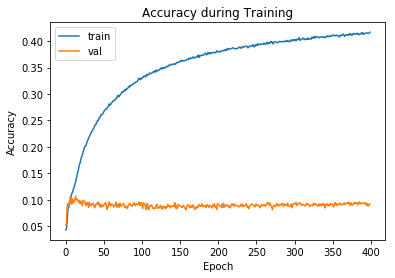

In [11]:
plot_accuracy(history)

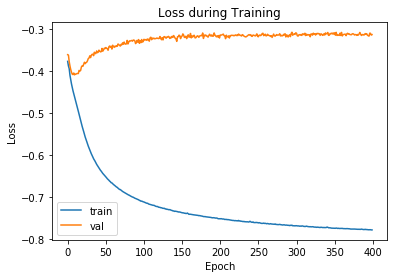

In [12]:
plot_loss(history)

In [21]:
from keras.models import model_from_json


# load json and create model if not already created
json_file = open('model_3LSTM_1Dense_5PercentDAta_400Epochs.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_Weights_3LSTM_1Dense_5PercentDAta_400Epochs.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:
def getTestingPhrase(sentence: str):
  if len(sentence.split()) != N:
    print("Sentence must contain exactly " + str(N) + " words.")
    return None
  return np.array([embeddings[i] for i in sentence.split()])


def printPredictions(predictions):
  num_outputs = predictions.shape[1]
  for i in range(num_outputs):
    print(embeddings.most_similar(positive=[predictions[0][i]], topn=1))

    
# This tale grew in the telling
test_input = getTestingPhrase("This tale grew in the")
print(test_input.shape)
test_input = np.expand_dims(test_input, axis=0)
print(test_input.shape)
predictions = model.predict(test_input)
print("The shape of the output is: " + str(predictions.shape))
printPredictions(predictions)

(5, 300)
(1, 5, 300)
The shape of the output is: (1, 5, 300)
[('story', 0.650792121887207)]
[('was', 0.7595184445381165)]
[('in', 0.9959137439727783)]
[('the', 0.9988061189651489)]
[('telling', 0.7336137294769287)]
